In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from keras.models import Model, load_model
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.layers import add

# Read Captions File

In [2]:
# Reading the Description file

with open("./Data/Flickr_TextData/Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()

In [3]:
captions = captions.split("\n")[:-1] # slicing the last element 40460

In [4]:
len(captions)

40460

In [5]:
print(captions[0])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [6]:
print(captions[0:])

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .', '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting', '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .', '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .', '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .', '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .', '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a painted rainb

In [8]:
first , second = captions[0].split('\t')
print(first.split("."))
print(first.split(".")[0])

['1000268201_693b08cb0e', 'jpg#0']
1000268201_693b08cb0e


In [7]:
#as we know each image is mapped with five captions
# creating a "descriptions" dictionary  where key is 'img_name' and value is list of captions corresponding to that image_file.

descriptions = {}

for ele in captions:
    i_to_c = ele.split("\t") # split the caption about \t or space
    img_name = i_to_c[0].split(".")[0] #1000268201_693b08cb0e.jpg#0 -> 1000268201_693b08cb0e
    cap = i_to_c[1]
    
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []

    descriptions[img_name].append(cap) # all the five captions will be added to a particular image id

In [8]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

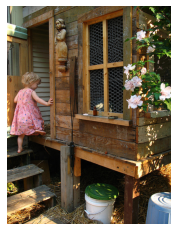

In [9]:
IMG_PATH = "Data/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #In the BGR color space, the order of color channels is Blue, Green, Red. In contrast, in the RGB color space, the order of color channels is Red, Green, Blue.
#Converting an image from BGR to RGB is a common task in computer vision applications because many other libraries and tools, such as Matplotlib, use the RGB color space convention.

plt.imshow(img)
plt.axis("off")
plt.show()

# Data Cleaning

In [10]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 1
    4 . remove numbers  """ 
# our text should be grammatically correct so ->
# don't remove stopwords
#don't do stemming 

# the reduction in vocab size , means less neurons , less paramters , less overfitting , and less time to compute prob 
def clean_text(sample):
    sample = sample.lower()
    
    sample = re.sub("[^a-z]+"," ",sample) # replace non-lower alphabet characters with space 
    
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    return sample

In [11]:
clean_text("My noghsujf si am m cricket101 &8 mphi*&86%%&??,BY6fajdn 213 q rqu243 boy  32 ewr wO>>J DHD 34  asfb HHGY Gvg HgB   231 123")

'my noghsujf si am cricket mphi by fajdn rqu boy ewr wo dhd asfb hhgy gvg hgb'

In [12]:
#  modify all the captions i.e - cleaned captions

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

In [13]:
#  clean descriptions

descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [16]:
# writing clean description to .txt file

f = open("descriptions.txt","w")
f.write( str(descriptions) )
f.close()

In [17]:
#  reading description file

f = open("../storage/descriptions.txt",'r')
descriptions = f.read()
f.close()
json_acceptable_string = descriptions.replace("'", "\"") #replace single quotes with backslashes, bcoz json doesnot accept strrings in single quotes 
descriptions = json.loads(json_acceptable_string) # loading to a python object

In [18]:
print(type(descriptions))

<class 'dict'>


In [19]:
# finding the unique vocabulary 

vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]] # splitting each sentence into list of words 
#The [...] syntax is a list comprehension, which is a compact way to create a list in Python.
# the words which appears more than one time , will be counted for just one time
#vocabulary set contains all the unique words in the product descriptions. However, there may be some words that are not 
# included in the vocabulary set for various reasons. Here are a few possibilities:
#Stop Words,Numbers,Rare Words
print('Vocabulary Size: %d' % len(vocabulary))
print(vocabulary)

Vocabulary Size: 8424
{'condoms', 'gaurdian', 'swatting', 'continues', 'empty', 'pelican', 'junk', 'florida', 'push', 'knoll', 'reds', 'navigating', 'bowler', 'ballplayers', 'towel', 'boatload', 'skii', 'shell', 'soocerball', 'casts', 'greenhouse', 'smeared', 'threshold', 'bags', 'wakeboarder', 'canvas', 'inside', 'mixing', 'strap', 'headphones', 'float', 'waterskies', 'alotment', 'surfaces', 'shares', 'emerald', 'doughnut', 'scope', 'violin', 'closely', 'firemen', 'pigs', 'housing', 'smu', 'miscellaneous', 'speedos', 'beverages', 'vaults', 'crates', 'cobblestones', 'withered', 'miniskirts', 'crows', 'heating', 'huts', 'rotating', 'alert', 'how', 'lifevest', 'fisher', 'circus', 'chris', 'curtain', 'shady', 'strips', 'yellowish', 'skydiver', 'shepherds', 'angel', 'within', 'competitively', 'crowds', 'defying', 'lines', 'energy', 'headress', 'cruisship', 'blocking', 'attire', 'nine', 'steap', 'device', 'signature', 'upfront', 'gather', 'broadly', 'mitsubishi', 'heads', 'flops', 'squeezed

In [20]:
#example
vocab = set()
vocab.update(["hello"])
vocab.update(["hello"])
vocab.update(["hi"])
print(vocab)

{'hello', 'hi'}


In [21]:
#  ALl words in description dictionary
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [22]:
#  count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

import collections

counter= collections.Counter(all_vocab)

dic_ = dict(counter)
print(dic_)
print(len(dic_))
threshold_value = 10
# sorting the dictionary according to freq count
sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1]) # sorting is reverse order so reverse equals to true
#lambda x: x[1] -> x taking the count value, child': 1545 -> x = 1545
sorted_dic = [x for x in sorted_dic if x[1]>threshold_value]
print(sorted_dic)
print(len(sorted_dic))
all_vocab = [x[0] for x in sorted_dic]

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [23]:
len(all_vocab)

1845

# Loading Training Testing Data

In [24]:
# TrainImagesFile
f = open("Data/Flickr_TextData/Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [25]:
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]
print(train)

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154', '2851304910_b5721199bc', '3423802527_94bd2b23b0', '3356369156_074750c6cc', '2294598473_40637b5c04', '1191338263_a4fa073154', '2380765956_6313d8cae3', '3197891333_b1b0fd1702', '3119887967_271a097464', '2276499757_b44dc6f8ce', '2506892928_7e79bec613', '2187222896_c206d63396', '2826769554_85c90864c9', '3097196395_ec06075389', '3603116579_4a28a932e2', '3339263085_6db9fd0981', '2532262109_87429a2cae', '2076906555_c20dc082db', '2502007071_82a8c639cf', '3113769557_9edbb8275c', '3325974730_3ee192e4ff', '1655781989_b15ab4cbff', '1662261486_db967930de', '2410562803_56ec09f41c', '2469498117_b4543e1460', '69710415_5c2bfb1058', '3414734842_beb543f400', '3006217970_90b42e6b27', '2192411521_9c7e488c5e', '3535879138_9281dc83d5', '2685788323_ceab14534a', '34

In [26]:
# TestImagesFile
f = open("Data/Flickr_TextData/Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [27]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]
print(test)

['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01', '2654514044_a70a6e2c21', '2339106348_2df90aa6a9', '256085101_2c2617c5d0', '280706862_14c30d734a', '3072172967_630e9c69d0', '3482062809_3b694322c4', '1167669558_87a8a467d6', '2847615962_c330bded6e', '3344233740_c010378da7', '2435685480_a79d42e564', '3110649716_c17e14670e', '2511019188_ca71775f2d', '2521770311_3086ca90de', '2723477522_d89f5ac62b', '2218609886_892dcd6915', '3745451546_fc8ec70cbd', '2844018783_524b08e5aa', '3100251515_c68027cc22', '2207244634_1db1a1890b', '2943023421_e297f05e11', '3286822339_5535af6b93', '2479652566_8f9fac8af5', '1394368714_3bc7c19969', '872622575_ba1d3632cc', '2309860995_c2e2a0feeb', '241347204_007d83e252', '3502343542_f9b46688e5', '757332692_6866ae545c', '2748729903_3c7c920c4d', '494792770_2c5f767ac0', '3213992947_3f3f967a9f', '2295750198_6d152d7ceb', '2358898017_24496b80e8', '3222055946_45f7293bb2', '444481722_690d0cadcf', '2647049

In [28]:
# prepare description for the training data 

In [29]:
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq 
# we will be using RNN technique to generate sentences from images 
train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        # startseq will go to first RNN cell
        # image vector for representing image 
        # its possible that we are making multiple sentences at a time for multiple images (10 images 10 sentences)
        #then for a image we will discard everything in a sentence when endsequence has been reached 
        train_descriptions[t].append(cap_to_append)

In [30]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# Data Preprocessing - Images

In [31]:
#transfer Learning 
#- images --> features
#- Text --> features

In [32]:
"""
In this section, we will load our images and do some processing so that we can feed it in our network.
"""

'\nIn this section, we will load our images and do some processing so that we can feed it in our network.\n'

In [33]:
#using pretrained models for extracting features 
#ResNet50 is a deep convolutional neural network architecture
#ResNet50 which is already trained on imagenet
#resnet50 having 50 layers (with most of the layers being convolutional layers) having shortcut  
#connections means skip one or more layers, allowing information to be passed directly from earlier layers to later ones. 
#This helps to address the problem of vanishing gradients that often occurs in very deep neural networks.
model = ResNet50(weights="imagenet", input_shape=(224,224,3)) 
#input_shape=(224,224,3): This argument specifies the expected shape of the input images that will be fed into the model.
#  In this case, the input images are expected to be 224 pixels wide and 224 pixels tall, with 3 color channels (i.e. RGB)

#This model now can be used for a variety of tasks, such as image classification or object detection, by training
#  it on a new dataset or using it as a feature extractor with transfer learning.


In [34]:
model.summary()
#The output shows the name of each layer in the model, its output shape, and the number of parameters it has. The first layer
#  in the example is an input layer with an output shape of (None, 224, 224, 3). The following layers are convolutional layers, 
# batch normalization layers, and activation layers that make up the ResNet50 architecture.


#last three layers 
#conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 #avg_pool (GlobalAveragePooling  (None, 2048)        0           ['conv5_block3_out[0][0]']       2D)                                                                                              
                                                                                                  
 #predictions (Dense)            (None, 1000)         2049000     ['avg_pool[0][0]'] 



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [35]:
# Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50

#extracting the features from GlobalAveragePooling2 layer 
#activation_98 having the size of 7*7*2048 means larger numbe rof neurons menas large number of parameters , 
#GlobalAveragePooling2 squeeze 1 channel(7*7) to 1 neuron. so 4048 neurons . 2048 will be the feature representation for the given input

# taking the model upto GlobalAveragePooling2 (GAP) and construct a new model (which is our dense layer)
#model.layers[-2] -> GlobalAveragePooling2
#model.layers[-2].output -> ?, 2048 
#once we pass our data through this GlobalAveragePooling2 we have ?,2048 output
model_new = Model(model.input, model.layers[-2].output)

In [36]:
#the preprocessed img goes through resnet50 conv base (model new) we get a feature vector. if we have m images we get m*2048 shape dimention output and store it into disk.
#img feature vector goes through -> img model caption

In [37]:
images = "./Data/Images/"

In [93]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224)) # define a fixed size to all images target_size=(224,224)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0) # when image is feed to resnet50 it has dimentions 224*224*3 ,
    #it cannot be feed with this dimentions to resnet50. [B , 224,224,3] B-> batch size [1 ,224,224,3] axis 0 is incremented to 1
    # normalization
    img = preprocess_input(img) # from tensorflow.keras.applications.resnet50
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


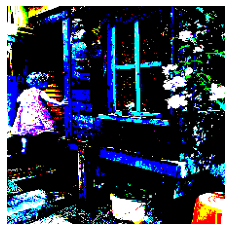

[[[[ -30.939003   -61.779      -67.68     ]
   [  13.060997     6.2210007  -17.68     ]
   [  34.060997    32.221        5.3199997]
   ...
   [ -99.939     -116.779     -118.68     ]
   [ -98.939     -111.779     -118.68     ]
   [-101.939     -108.779     -120.68     ]]

  [[ -36.939003   -68.779      -72.68     ]
   [  21.060997     9.221001   -13.68     ]
   [  38.060997    37.221        8.32     ]
   ...
   [ -94.939     -104.779     -113.68     ]
   [ -93.939     -108.779     -116.68     ]
   [ -90.939      -86.779     -102.68     ]]

  [[ -39.939003   -74.779      -76.68     ]
   [  26.060997    13.221001    -9.68     ]
   [  41.060997    36.221        6.3199997]
   ...
   [ -99.939     -107.779     -115.68     ]
   [-101.939     -107.779     -121.68     ]
   [ -95.939     -101.779     -123.68     ]]

  ...

  [[ -27.939003    56.221      107.32     ]
   [ -92.939      -49.779       20.32     ]
   [ -49.939003   -13.778999    35.32     ]
   ...
   [ 150.061      132.22101    126.

In [94]:
img = preprocess_image(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0]) #clipping the input data to the valid range for imshow with RGB data .
#mean substraction of each pixel of each channel from the mean of color 
plt.axis("off")
plt.show()
print(img)

In [40]:
def encode_image(img):
    img = preprocess_image(img) # preprocessed image
    feature_vector = model_new.predict(img) #feature vector
    print(feature_vector.shape)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [41]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

1/1 [==============================] - 3s 3s/step
(1, 2048)


array([0.06536551, 0.16782704, 0.32518464, ..., 0.05111536, 0.3281792 ,
       1.0043334 ], dtype=float32)

In [45]:
#isko run mat karna

# encoding all images 
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image
#train contains the number(img_id) of a image 
for ix, img in enumerate(train):
    #IMG_PATH = "Data/Images/"
    img_path =IMG_PATH+"/"+img+".jpg"
    encoding_train[img[len(images):]] = encode_image(img_path)
    if ix%100==0:
        print("Encoding image- "+ str(ix))    
print("Time taken in seconds =", time()-start)

1/1 [==============================] - 0s 128ms/step
(1, 2048)
Encoding image- 0
1/1 [==============================] - 0s 140ms/step
(1, 2048)
1/1 [==============================] - 0s 133ms/step
(1, 2048)
1/1 [==============================] - 0s 192ms/step
(1, 2048)
1/1 [==============================] - 0s 194ms/step
(1, 2048)
1/1 [==============================] - 0s 206ms/step
(1, 2048)
1/1 [==============================] - 0s 185ms/step
(1, 2048)
1/1 [==============================] - 0s 163ms/step
(1, 2048)
1/1 [==============================] - 0s 200ms/step
(1, 2048)
1/1 [==============================] - 0s 171ms/step
(1, 2048)
1/1 [==============================] - 0s 174ms/step
(1, 2048)
1/1 [==============================] - 0s 192ms/step
(1, 2048)
1/1 [==============================] - 0s 162ms/step
(1, 2048)
1/1 [==============================] - 0s 150ms/step
(1, 2048)
1/1 [==============================] - 0s 178ms/step
(1, 2048)
1/1 [==============================] 

In [46]:
# Save the bottleneck train features to disk

with open("../storage/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [48]:
start = time()
encoding_test = {}
for ix, img in enumerate(test):
    img = IMG_PATH+"/"+img+".jpg"
    encoding_test[img[len(images):]] = encode_image(img)
    if ix%100==0:
        print("Encoding image- "+ str(ix))
print("Time taken in seconds =", time()-start)

1/1 [==============================] - 2s 2s/step
(1, 2048)
Encoding image- 0
1/1 [==============================] - 1s 1s/step
(1, 2048)
1/1 [==============================] - 1s 1s/step
(1, 2048)
1/1 [==============================] - 1s 1s/step
(1, 2048)
1/1 [==============================] - 2s 2s/step
(1, 2048)
1/1 [==============================] - 2s 2s/step
(1, 2048)
1/1 [==============================] - 1s 1s/step
(1, 2048)
1/1 [==============================] - 2s 2s/step
(1, 2048)
1/1 [==============================] - 1s 961ms/step
(1, 2048)
1/1 [==============================] - 1s 1s/step
(1, 2048)
1/1 [==============================] - 1s 1s/step
(1, 2048)
1/1 [==============================] - 2s 2s/step
(1, 2048)
1/1 [==============================] - 2s 2s/step
(1, 2048)
1/1 [==============================] - 1s 1s/step
(1, 2048)
1/1 [==============================] - 1s 1s/step
(1, 2048)
1/1 [==============================] - 1s 1s/step
(1, 2048)
1/1 [==============

In [49]:
# Save the bottleneck train features to disk

with open("../storage/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [50]:
# Load the train images features from disk

with open("../storage/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [51]:
# Load the test images features from disk

with open("../storage/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [ ]:
# so we have now converted images into captions , now we will be converting our captions into numbers

# Data Preprocessing - Captions

In [ ]:
#when we feen data to our model , every word is a feature and that feature should be represented usig a number

In [52]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""


ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1    

In [53]:
#  need to add these 2 words as well

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [54]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [55]:
#maximum length oof caption that we can have
all_captions_len = []
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


In [ ]:

with open("../storage/word_to_idx.pkl", 'wb') as w2i:
    pickle.dump(w2i)
    
with open("../storage/idx_to_word.pkl", 'wb') as i2w:
    pickle.dump(i2w)

# Data Preparation using Generator Function

In [ ]:
#setting up as supervised learning problem [image captioning]

#Y = f(x) 
#Y -> caption 
#f(x) -> image
#x the image we give

In [ ]:
#how does sentence geenration happens
#u cannot geenrate entire sentence of a image at a time
#using RNN technique -> each word for a gievn image will be predicted

#Dog was running
#P(Running|<s> Dog was)
#P(was|<s> Dog)
#P(Dog|<s>)
#this is called language modeling
#P(Wt+1 | w1 , w2 .........wt) predict the next word given that u already know what are the correct words from w1 .....wt 

#ground truth -> Dog was jumping <- Y actual
#pred -> Dog is fighting <- output 

#input                Yactual      Ypred
#<s>                  Dog          Dog
#<s>Dog               was          is  
#<s>Dog was           jumping      playing
#<s>Dog was jumping  

#Ypred is creted during training time ,at test time we don't have Yactual , so we pass Ypred.

#although our prediction is wrong but we are going to provide actual ground truth as input   
#prob of sentence = [P(w1|w0)*P(w2|w0 w1)*P(w3|w0 w1 w2)....]


# in our actual learning we have 6000 training images(8000 in total), each having 5 captions . this makes a total of 30000 images and captions

#if we assume that each caption on a avg , is just 10 words long, it lead to total of 30000*10 training points

In [96]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):
    X1, X2, y = [], [], []
    n=0
    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1
            try:
                photo = encoding_train[key+".jpg"]
            except KeyError:
                continue

            for desc in desc_list: # iterating through eaach caption of the image
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):
                    #supervised learning -> in_seq and out_seq
                    in_seq = seq[0:i] # the inputs 
                    out_seq = seq[i] #the output 
                    # 0 denotes padding word
                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo) #2048 vector 
                    X2.append(in_seq) #35 dim -> later will be converted to glove embedding
                    y.append(out_seq) #the vocab size ~1800
                    # we got our traing point

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

# Word Embedding

In [ ]:
# we ahve learned transfer learning is used for images and text
# RNN layer
# whenever we feed data into RNN layer , that data should be passed from embedded layer 
# we will preinitialize this embedded layer , for that we are going to use glove vector 

In [92]:
f = open("./glove/glove.6B.50d.txt", encoding='utf8')
#6B means 6 billion words

In [76]:
embedding_index = {}
for line in f:
    values = line.split() # reading every line of glove embedding
    word = values[0] 
    coefs = np.asarray(values[1:], dtype="float")
    embedding_index[word] = coefs
    # Each value represents a pair of words that occur together in the co-occurrence matrix.
    #example for a word -->
f.close()

In [77]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

## Converting words into vectors  Directly - (Embedding Layer Output)

In [ ]:
#out of 6 billion words we have to only keep the words which are in our vocab 
# if a word there in vocab is not present in Glove 6B , then that word will be initialized with 0.

In [78]:
def get_embedding_output():
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)  # asking the embedding if the word is present or not
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector        
    return embedding_output
embedding_output = get_embedding_output() # getting the embedding vector for every word in a vocab

In [79]:
embedding_output.shape

(1848, 50)

In [80]:
embedding_output[1847] # the endseq

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Model Architecture

In [81]:
# image feature extractor model
input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.5)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [82]:
# partial caption sequence model
input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.5)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [83]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [84]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 35, 50)       92400       ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

In [85]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [86]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

# Train Our Model

In [99]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('../model_weights/model_' + str(i) + '.h5')

In [39]:
model = load_model("../model_weights/model_9.h5")

# Predictions

In [40]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

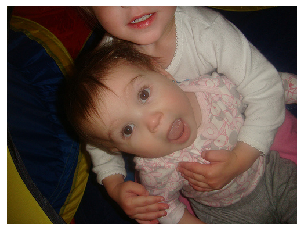

little boy in blue shirt is holding child in the bathroom


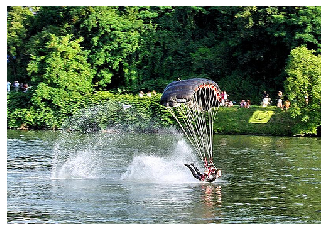

man in yellow shirt and black shorts is wakeboarding in the water


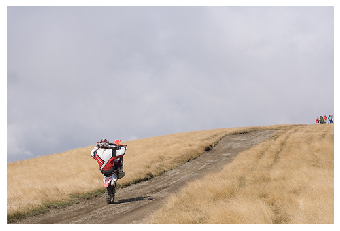

man in red shirt and khaki helmet is standing on top of mountain


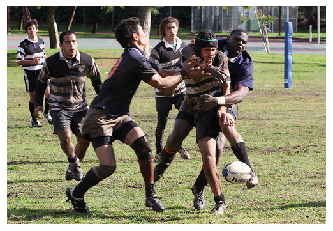

two men in sports uniforms are playing soccer


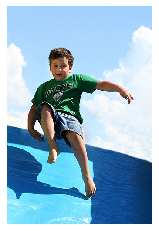

young boy in blue shorts is jumping into the air


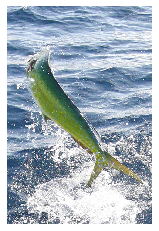

the surfer is leaping into the air


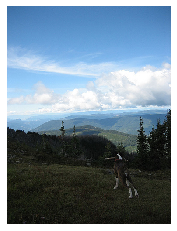

two dogs are running on the grass


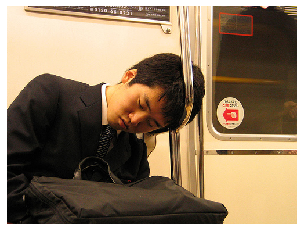

man with glasses and black leather is sitting in front of brick wall


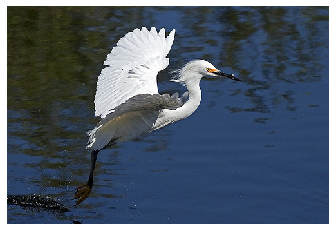

white crane flying over lake


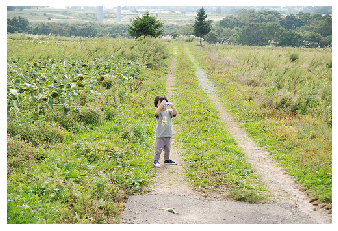

group of people are walking down path in field


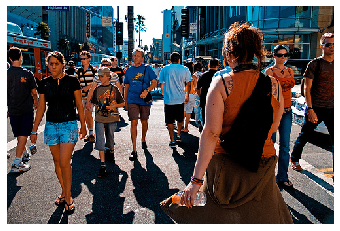

many people are standing around crowded street


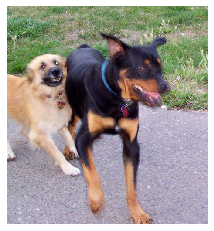

two dogs are playing with each other in the grass


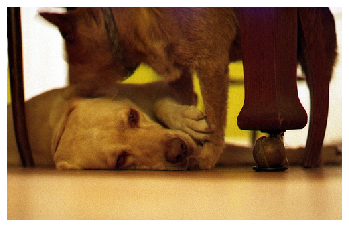

two dogs are tied around


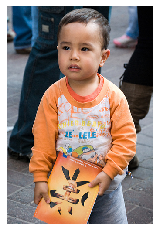

little boy in red shirt is holding onto child face


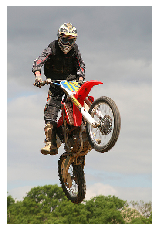

man on motorcycle riding his bike on dirt track


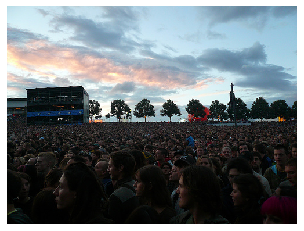

crowd of people are sitting around in line of large yellow firetruck


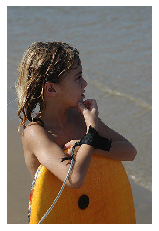

young boy in blue bathing suit is standing on the beach


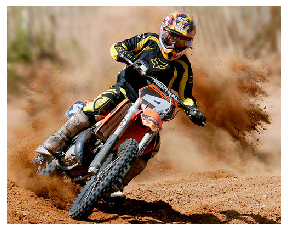

man on motorcycle is driving on dirt track


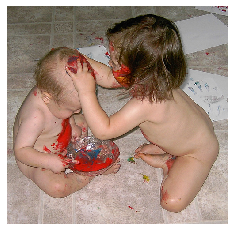

little boy in blue shirt is playing with water wand


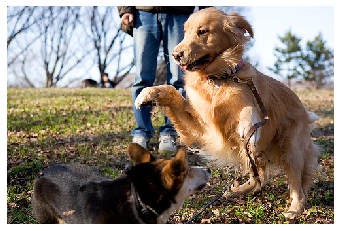

two dogs are playing together in the grass


In [43]:
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)